In [0]:
#https://arxiv.org/pdf/1511.06434.pdf

In [0]:
pip install tqdm -U

     |████████████████████████████████| 61kB 2.4MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
 !unzip '/content/drive/My Drive/colab_datasets/img_align_celeba.zip' -d '/content/drive/My Drive/colab_datasets/celeba'


In [0]:
from torchvision import transforms, datasets
import torch as torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# params
image_size = 64
bs=128
std,mean = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) #normalization of image
real_label=1
fake_label=0
lr=0.0002
beta=0.5
nz=100

In [0]:
compose = transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize(std, mean),
                              ])

In [0]:
cifar = datasets.CIFAR10(root='cifar10', download=True, train=True, transform=compose)
dataset = [ds for ds in tqdm(cifar) if ds[1] == 5]

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 92452152.65it/s]                               


Extracting cifar10/cifar-10-python.tar.gz to cifar10


In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True,)

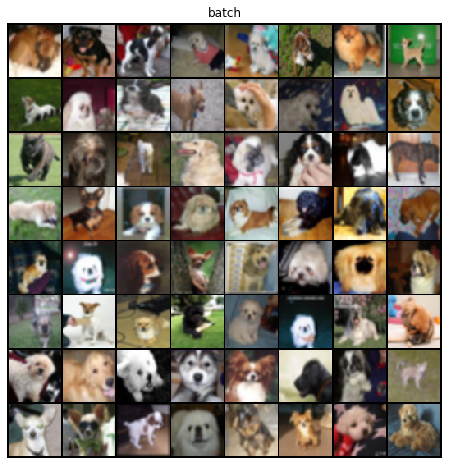

In [0]:
batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("batch")
plt.imshow(vutils.make_grid(batch[0][:64], padding=2, normalize=True).cpu().permute(1,2,0))

In [0]:
def imshow(img, std, mean):
  img = img.permute(1,2,0).cpu()
  img = img * torch.tensor(std) + torch.tensor(mean)
  img = np.clip(img, 0, 1)
  plt.imshow(img)

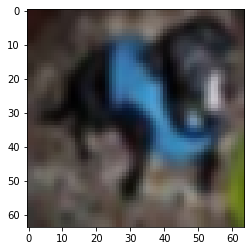

In [0]:
imshow(dataset[0][0],std,mean)

In [0]:
def weights_init(m):
    module_name = m.__class__.__name__
    if 'Conv' in module_name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in module_name:
      #https://discuss.pytorch.org/t/weight-initialization-for-batchnorm-in-dcgan-tutorial/32351
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
def convT_bn(in_channels,
             out_channels,
             kernel_size,
             stride, padding, 
             bias=False, 
             act=nn.ReLU(True)):
  layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
  layers.append(nn.BatchNorm2d(out_channels))
  layers.append(act)
  return layers

#from ConvTranspose2d doc:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
#p=((Hin-1)*s+k-Hout)/2
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
          *convT_bn(nz,512,4,1,0), #p=((1-1)*2+4-4)/2 => p=0
          *convT_bn(512, 256,4,2,1),
          *convT_bn(256,128,4,2,1),
          *convT_bn(128,64,4,2,1),
          *convT_bn(64,3,4,2,1,act=nn.Tanh()),
        )
    def forward(self, input):
        return self.layers(input)

In [0]:
def conv_bn(in_channels,
            out_channels,
            kernel_size,
            stride, padding, 
            bias=False, 
            act=nn.LeakyReLU(0.2,True)):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)]
  layers.append(nn.BatchNorm2d(out_channels))
  layers.append(act)
  return layers


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
          *conv_bn(3,64,4,2,1),
          *conv_bn(64,128,4,2,1),
          *conv_bn(128,256,4,2,1), 
          *conv_bn(256,512,4,2,1),
          *conv_bn(512,1,4,1,0,act=nn.Sigmoid()),
        )
    def forward(self, input):
        return self.layers(input)

In [0]:
a = torch.rand([2,3,64,64],device=device).float()
print(a.shape)
for l in discriminator.layers:
  a = l(a)
  print(a.shape)
#a1 = discriminator.layers[0](x)
#print(a1.shape)

torch.Size([2, 3, 64, 64])
torch.Size([2, 64, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 256, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 512, 4, 4])
torch.Size([2, 512, 4, 4])
torch.Size([2, 512, 4, 4])
torch.Size([2, 1, 1, 1])
torch.Size([2, 1, 1, 1])
torch.Size([2, 1, 1, 1])


In [0]:
def fit(epochs, iterator, criterion, optimizer_g, optimizer_d,discriminator,generator):
  for epoch in range(epochs):
    for batch in tqdm(iterator):
      bs=batch[1].shape[0]
      # Train disciminator
      # Train with real samples
      optimizer_d.zero_grad()
      y=torch.full_like(batch[1], real_label, device=device).float()
      yhat=discriminator(batch[0].to(device)).view(-1)
      loss_real=criterion(yhat,y)
      loss_real.backward()

      # Train with fake samples
      noise = torch.randn(bs, nz, 1, 1, device=device)
      fake_images = generator(noise)
      y=torch.full_like(batch[1], fake_label,device=device).float()
      yhat=discriminator(fake_images).view(-1)
      loss_fake=criterion(yhat,y)
      loss_fake.backward()

      optimizer_d.step()
      loss_d = loss_real + loss_fake
#      print(loss_d)
      # Train generator
      optimizer_g.zero_grad()
      noise = torch.randn(bs, nz, 1, 1, device=device)
      fake_images = generator(noise)
      y=torch.full_like(batch[1], real_label, device=device).float() #generator must create real images
      yhat=discriminator(fake_images).view(-1)
      loss_g = criterion(yhat,y)
      loss_g.backward()
      optimizer_g.step()

In [0]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
pass

In [0]:
criterion = nn.BCELoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999))

In [0]:
fit(10, dataloader, criterion, optimizer_g, optimizer_d, discriminator, generator)

In [0]:
 with torch.no_grad():
  noise = torch.randn(bs, nz, 1, 1, device=device)
  fake_images = generator(noise)

5000

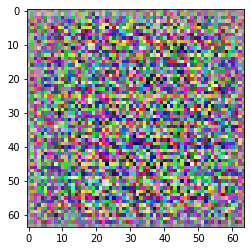

In [0]:
imshow(fake_images[0],std,mean)

In [0]:
batch = next(iter(dataloader))
batch[1].shape[0]

128

In [0]:
optimizer_d.zero_grad()
yhat=discriminator(batch[0].to(device)).view(-1)
y=torch.full_like(batch[1], real_label, device=device).float()
loss_real=criterion(yhat,y)
loss_real.backward()

In [0]:
# Train with fake samples
noise = torch.randn(bs, nz, 1, 1, device=device)
fake_images = generator(noise)
y=torch.full_like(batch[1], fake_label,device=device).float()
yhat=discriminator(fake_images).view(-1)
loss_fake=criterion(yhat,y)
loss_fake.backward()

In [0]:
#.view(-1, 1).squeeze(1)
discriminator(batch[0].to(device)).view(-1, 1).squeeze(1).shape

torch.Size([128])